# Gensim model

In [1]:
import pandas as pd
from pprint import pprint
from gensim.models.ldamodel import LdaModel
import gensim.corpora as corpora
from gensim.corpora import MmCorpus
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
import pyLDAvis.gensim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv("bbc-text.csv")
stopword_list = stopwords.words("english")
stopword_list = stopword_list + ["said", "also", "would", "first", "last", "one", "like", "could", "us", "uk", "year"]

In [3]:
def preprocess_gensim(df):
    df['text'] = df['text'].apply(lambda x: simple_preprocess(x))
    df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stopword_list])
    return df

In [4]:
def create_lda_model_gensim(id_dict, corpus, num_topics):
    lda_model = LdaModel(corpus=corpus,
                         id2word=id_dict,
                         num_topics=num_topics, 
                         random_state=100,
                         chunksize=100,
                         passes=10)
    return lda_model

In [5]:
df = preprocess_gensim(df)
texts = df['text'].values
id_dict = corpora.Dictionary(texts)
corpus = [id_dict.doc2bow(text) for text in texts]
number_topics = 5
lda_model = create_lda_model_gensim(id_dict, corpus, number_topics)
pprint(lda_model.print_topics())

[(0,
  '0.018*"mr" + 0.007*"people" + 0.006*"government" + 0.006*"blair" + '
  '0.006*"labour" + 0.005*"party" + 0.004*"election" + 0.004*"told" + '
  '0.004*"minister" + 0.004*"new"'),
 (1,
  '0.014*"film" + 0.010*"best" + 0.006*"music" + 0.005*"show" + 0.005*"awards" '
  '+ 0.005*"new" + 0.005*"number" + 0.004*"album" + 0.004*"award" + '
  '0.004*"tv"'),
 (2,
  '0.011*"people" + 0.006*"mobile" + 0.006*"technology" + 0.006*"new" + '
  '0.005*"net" + 0.005*"use" + 0.005*"digital" + 0.005*"many" + 0.004*"music" '
  '+ 0.004*"software"'),
 (3,
  '0.011*"bn" + 0.008*"sales" + 0.005*"company" + 0.005*"market" + '
  '0.005*"growth" + 0.004*"firm" + 0.004*"new" + 0.004*"bank" + 0.004*"rise" + '
  '0.004*"economic"'),
 (4,
  '0.007*"game" + 0.006*"time" + 0.006*"england" + 0.005*"players" + '
  '0.005*"world" + 0.005*"back" + 0.005*"win" + 0.005*"two" + 0.005*"team" + '
  '0.004*"play"')]


# Topic coherence: choosing number of topics

In [6]:
def plot_coherence(id_dict, corpus, texts):
    num_topics_range = range(2, 10)
    coherences = []
    for num_topics in num_topics_range:
        lda_model = create_lda_model_gensim(id_dict, corpus, num_topics)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id_dict, coherence='c_npmi')
        coherences.append(coherence_model_lda.get_coherence())
    plt.plot(num_topics_range, coherences, color='blue', marker='o', markersize=5)
    plt.title('Coherence as a function of number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')
    plt.grid()
    plt.show()

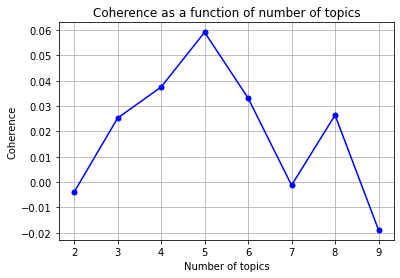

In [ ]:
plot_coherence(id_dict, corpus, texts)

# Visualization

In [ ]:
lda_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id_dict)
pyLDAvis.show(lda_prepared)

# Save model

In [ ]:
def save_model(lda, lda_path, id_dict, dict_path, corpus, corpus_path):
    lda.save(lda_path)
    id_dict.save(dict_path)
    MmCorpus.serialize(corpus_path, corpus)

# Train-test split

In [ ]:
df = pd.read_csv("bbc-text.csv")
stopword_list = stopwords.words("english")
stopword_list = stopword_list + ["said", "also", "would", "first", "last", "one", "like", "could", "us", "uk", "year"]
df = preprocess_gensim(df)

In [ ]:
#labels = ["business", "sport", "tech", "entertainment", "politics"]
#le = preprocessing.LabelEncoder()
#le.fit(labels)
#df['encoded_label'] = df['category'].apply(lambda x: le.transform([x])[0])
dt_df = df.to_numpy()
train, test = train_test_split(dt_df, test_size=0.2)

In [ ]:
texts = train[:,1]
id_dict = corpora.Dictionary(texts)
corpus = [id_dict.doc2bow(text) for text in texts]
number_topics = 5
lda_model = create_lda_model_gensim(id_dict, corpus, number_topics)
pprint(lda_model.print_topics())

In [ ]:
def predict(model, id_dict, input_string):
    input_list = simple_preprocess(input_string)
    input_list = [word for word in input_list if word not in stopword_list]
    bow = id_dict.doc2bow(input_list)
    topics = model[bow]
    topic, probability = max(topics, key=lambda item: item[1])
    return topic

In [ ]:
new_example = """Manchester United players slumped to the turf 
at full-time in Germany on Tuesday in acknowledgement of what their 
latest pedestrian first-half display had cost them. The 3-2 loss at 
RB Leipzig means United will not be one of the 16 teams in the draw 
for the knockout stages of the Champions League. And this is not the 
only price for failure. The damage will be felt in the accounts, in 
the dealings they have with current and potentially future players 
and in the faith the fans have placed in manager Ole Gunnar Solskjaer. 
With Paul Pogba's agent angling for a move for his client and ex-United 
defender Phil Neville speaking of a "witchhunt" against his former team-mate 
Solskjaer, BBC Sport looks at the ramifications and reaction to a big loss for United."""
topics = predict(lda_model, id_dict, new_example)
print(topics)
topic, probability = max(topics, key=lambda item: item[1])
print(topic, probability)

# Evaluation

In [ ]:
num_to_labels = {0:"entertainment", 1:"politics", 2:"business", 3:"sport", 4:"tech"}
labels_to_num = {"entertainment": 0, "politics":1, "business":2, "sport":3, "tech":4}
test_df = pd.DataFrame(test, columns=["category", "text"])
test_df["predicted"] = test_df["text"].apply(lambda x: predict(lda_model, id_dict, " ".join(x)))
test_df["gold"] = test_df["category"].apply(lambda x: labels_to_num[x])
print(classification_report(test_df["gold"].to_numpy(), test_df["predicted"].to_numpy(), 
                            labels=list(num_to_labels.keys()), target_names=list(labels_to_num.keys())))

In [ ]:
cm = confusion_matrix(test_df["gold"].to_numpy(), test_df["predicted"].to_numpy())
print(cm) # predicted horizontal, actual vertical